[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using Colab cache for faster access to the 'nips-papers' dataset.
Loaded NIPS dataset with 7241 records
Graph constructed with 52 keywords and 1226 edges


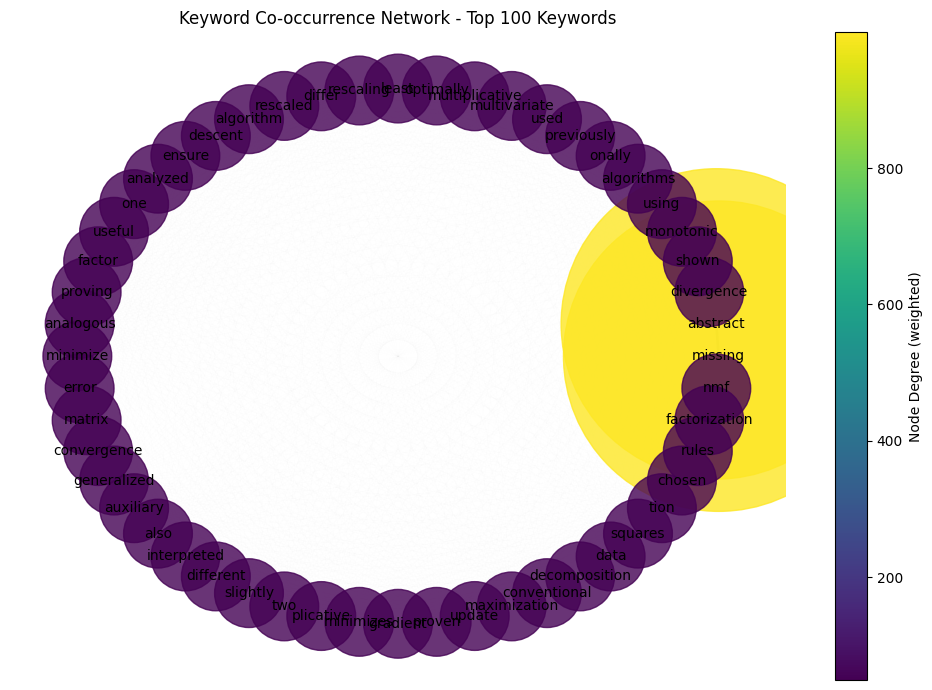

In [ ]:
# Install dependencies if needed:
# pip install kagglehub pandas networkx matplotlib nltk

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import combinations
import string
from collections import Counter

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource

def load_nips_dataset():
    # The NIPS dataset has a file named 'papers.csv'
    file_path = "papers.csv"
    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "benhamner/nips-papers",
        file_path
    )
    print(f"Loaded NIPS dataset with {len(df)} records")
    return df

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [
        t for t in tokens
        if t not in stop_words and t not in string.punctuation and len(t) > 2 and t.isalpha()
    ]
    return tokens

def filter_tokens_by_frequency(token_lists, min_freq=5):
    """Filter tokens that appear in fewer than min_freq documents."""
    doc_freq = Counter()
    for tokens in token_lists:
        unique_tokens = set(tokens)
        doc_freq.update(unique_tokens)

    filtered_token_lists = []
    for tokens in token_lists:
        filtered = [t for t in tokens if doc_freq[t] >= min_freq]
        filtered_token_lists.append(filtered)
    return filtered_token_lists, doc_freq

def build_keyword_cooccurrence_network(token_lists):
    G = nx.Graph()
    for tokens in token_lists:
        unique_tokens = list(set(tokens))
        for kw1, kw2 in combinations(unique_tokens, 2):
            if G.has_edge(kw1, kw2):
                G[kw1][kw2]['weight'] += 1
            else:
                G.add_edge(kw1, kw2, weight=1)
    print(f"Graph constructed with {G.number_of_nodes()} keywords and {G.number_of_edges()} edges")
    return G

def visualize_network(G, top_n=100): # Increased top_n to 100
    degrees = dict(G.degree(weight='weight'))
    # Filter out nodes that are not in the graph before sorting
    valid_nodes = [node for node in G.nodes() if node in degrees]
    top_nodes = sorted(valid_nodes, key=degrees.get, reverse=True)[:top_n]
    subgraph = G.subgraph(top_nodes)

    fig, ax = plt.subplots(figsize=(10, 7))  # Create figure and axes explicitly
    # Changed from nx.spring_layout to nx.circular_layout
    pos = nx.circular_layout(subgraph)

    # Ensure node_sizes and node_colors are only for nodes in the subgraph
    subgraph_degrees = dict(subgraph.degree(weight='weight'))
    node_sizes = [subgraph_degrees[node] * 50 for node in subgraph.nodes()] # Reduced node size multiplier
    node_colors = [subgraph_degrees[node] for node in subgraph.nodes()]
    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [weight / max_weight * 2 for weight in edge_weights] # Reduced edge width multiplier

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors,
                           cmap=plt.cm.viridis, alpha=0.8, ax=ax) # Pass ax
    nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.6, edge_color='gray', ax=ax) # Pass ax
    nx.draw_networkx_labels(subgraph, pos, font_size=10, ax=ax) # Pass ax

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                               norm=plt.Normalize(vmin=min(node_colors) if node_colors else 0, vmax=max(node_colors) if node_colors else 1))
    sm.set_array([])
    plt.colorbar(sm, label="Node Degree (weighted)", ax=ax) # Pass ax

    ax.set_title(f"Keyword Co-occurrence Network - Top {top_n} Keywords") # Set title on ax
    ax.axis('off') # Turn off axis on ax
    plt.tight_layout()
    plt.show()

def main():
    df = load_nips_dataset()
    # Use abstracts for text analysis, drop missing
    abstracts = df['abstract'].dropna().astype(str).head(1000)  # limit to 1000 for speed

    token_lists = [preprocess_text(text) for text in abstracts]

    # Filter tokens appearing in fewer than 5 abstracts
    # token_lists, doc_freq = filter_tokens_by_frequency(token_lists, min_freq=5) # Commenting out frequency filter

    # Print top 20 keywords by document frequency (this will now show all tokens)
    # doc_freq = Counter()
    # for tokens in token_lists:
    #     unique_tokens = set(tokens)
    #     doc_freq.update(unique_tokens)
    # top_keywords = doc_freq.most_common(20)
    # print("Top 20 keywords by document frequency:")
    # for word, freq in top_keywords:
    #     print(f"{word}: {freq}")


    G = build_keyword_cooccurrence_network(token_lists)
    visualize_network(G, top_n=100) # Increased top_n to 100

if __name__ == "__main__":
    main()